basic loads

In [1]:
from os import listdir
from os.path import isfile, join
import sys
sys.path.append("/Users/andyreagan/tools/python")
from kitchentable.dogtoys import *
from json import loads
from re import findall,UNICODE
from labMTsimple.labMTsimple.speedy import LabMT
my_LabMT = LabMT()
from labMTsimple.labMTsimple.storyLab import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from database.bookclass import Book_raw_data
import pickle

import os
sys.path.append('/Users/andyreagan/projects/2014/09-books/database')
os.environ.setdefault('DJANGO_SETTINGS_MODULE','gutenbergdb.settings')
import django
django.setup()

from library.models import *

from datetime import datetime



loading LabMT with stopVal=0.0, for 10222 words


In [2]:
# all our essentials
from matplotlib import rc,rcParams
# rc('font', family='sans-serif') 
# rc('font', serif='Helvetica Neue')
# rc('text', usetex='false') 

rc('font', family='serif')
rc('font', family='cmr10')
rc('text', usetex='false') 

rcParams.update({'font.size': 12})
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
q = Book.objects.filter(exclude=False,
                        length__gt=10000,
                        length__lte=200000,
                        downloads__gte=150,
                        numUniqWords__gt=1000,
                        numUniqWords__lt=18000,
                        lang_code_id=0).order_by("gutenberg_id")

In [4]:
use_cache = False
num_points = 200
if isfile("data/gutenberg/timeseries-salad-matrix-cache.p") and use_cache:
    big_matrix = pickle.load(open("data/gutenberg/timeseries-salad-matrix-cache.p","rb"))
else:
    # load all of the timeseries into a matrix
    big_matrix = np.ones([len(q),num_points])
    # big_matrix_mean0 = np.ones(big_matrix.shape)
    stop_val = 1.0
    for i,b in enumerate(q):
        if i%25 == 0:
            print(i)
        # print(b.title)
        b_data = Book_raw_data(b)
        a = b_data.chopper_sliding(my_LabMT,num_points=num_points,stop_val=stop_val,randomize=True)
        big_matrix[i,:] = b_data.timeseries
    print(big_matrix.shape)
    pickle.dump(big_matrix,open("data/gutenberg/timeseries-salad-matrix-cache.p","wb"),pickle.HIGHEST_PROTOCOL)
    
big_matrix_mean0 = big_matrix-np.tile(big_matrix.mean(axis=1),(num_points,1)).transpose()
big_matrix_start0 = big_matrix-np.tile(big_matrix[:,0],(num_points,1)).transpose()
print(big_matrix.shape)

0
25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475
500
525
550
575
600
625
650
675
700
725
750
775
800
825
850
875
900
925
950
975
1000
1025
1050
1075
1100
1125
1150
1175
1200
1225
1250
1275
1300
1325
1350
1375
1400
1425
1450
1475
1500
1525
1550
1575
1600
1625
1650
1675
1700
1725
1750
(1751, 200)
(1751, 200)


potentially useful 

In [5]:
def mysub2ind(i,n,m):
    # convert the i-th index of a flattened n x m matrix
    # into the i,j of that matrix
    j = int(np.floor(i/float(m)))
    k = i-m*j
    return j,k

In [6]:
def myind2sub(j,k,n,m):
    # convert the [j,k]-th index of an n x m matrix
    # into the i of the flattened matrix
    i = j*n + k
    return int(i)

assert myind2sub(mysub2ind(20,15,15)[0],mysub2ind(20,15,15)[1],15,15) == 20

this is the main function
=========================

In [7]:
# function [B,rmse_all] = train_SOM(A,B,C,numiter,randorder,scaling_fun,nbd_fun,iterstart)
def train_SOM(data,node_states,network_size,numiter,scaling_fun,nbd_fun,randorder=True,iterstart=0,returnDis=False):
    # train an SOM on the data, which is (sample x feature)
    # i.e. books going down, timeseries going across (or PCA
    # coeff across...)
    # INPUTS
    # data: (training pattern i, timeseries j)
    # node_states: initial state of the nodes (num_nodes, features e.g. timeseries length)
    # network_size: tuple of (m,n) size of the network

    num_training_patterns = data.shape[0]
    print(num_training_patterns)
    num_nodes = node_states.shape[0]
    # or, network_size[0]*network_size[1]
    # precompute the distance from each node, to the others
    # this is a distance matrix
    # I'm thinking about this as taking steps on the grid
    # and no torus
    pairwise_distances = np.zeros([num_nodes,num_nodes])
    for i in range(num_nodes):
        for j in range(num_nodes):
            ind1 = mysub2ind(i,network_size[0],network_size[1])
            ind2 = mysub2ind(j,network_size[0],network_size[1])
            pairwise_distances[i,j] = np.abs(ind1[0]-ind2[0])+np.abs(ind1[1]-ind2[1])
    print("pairwise distance:")
    print(pairwise_distances[5,:])
    # plt.figure(figsize=(10,10))
    # plt.imshow(pairwise_distances)
    # plt.title('pairwise distance matrix')
    # mysavefig('SOM-5x5-distanceMatrix.png')
    # plt.show()

    rmse_avg = np.zeros(numiter)

    print('going for {0} iterations now'.format(numiter))
    for i in range(iterstart,numiter+iterstart):
        print('on training iteration no {0}'.format(i))
        order = np.arange(num_training_patterns)
        # order = np.arange(1)

        if randorder:
            np.random.shuffle(order)

        # go get the scaling parameter
        scaling_coeff = scaling_fun(i)
        print('scaling coeff is {0}'.format(scaling_coeff))
        
        # print(order)
        for j in order:
            # find the index of the winner
            # print(data[j,:])
            diff = node_states-data[j,:]
            dist = np.sqrt(np.sum(diff**2,axis=(1)))
            # print(dist)
            min_dist = dist.min()
            winning_node = dist.argmin()

            # print('winning node is {0}'.format(winning_node))
            rmse_avg[i-iterstart] += min_dist
            nbd,nbd_coeffs = nbd_fun(i,pairwise_distances[winning_node,:])
            # print('tuning the nbd of size {0}'.format(len(nbd)))
            # print(nbd)
            for n,a in zip(nbd,nbd_coeffs):
                # print(n)
                # print(a.shape)
                # print(node_states[n,:])
                # print(data[j,:].shape)
                # print(node_states[n,:]-data[j,:])
                # print(scaling_coeff)
                # print(a)
                node_states[n,:] = node_states[n,:] - scaling_coeff*a*(node_states[n,:]-data[j,:])
                # print('after:')
                # print(node_states[n,:])

    # here is the MATLAB code for this:
    # % INPUTS
    # %
    # % A(size input,num training patterns)
    # % the training patterns
    # %
    # % B(size input,num nodes in kohonen)
    # % the m_i states of the nodes
    # %
    # % C(num nodes,num nodes)
    # % adjacency matrix for the nodes
    # %
    # % OUTPUT
    # %
    # % B: kohenen matrix values
    # 
    # % how long to train
    # % numiter = 50;
    # % taking this from input
    # 
    # num_training_patterns = length(A(1,:));
    # num_nodes = length(B(1,:));
    # 
    # % rmse_all = ones(num_training_patterns+(1-traintogether)* ...
    # %                 num_training_patterns,numiter);
    # rmse_all = ones(num_training_patterns,numiter);
    # 
    # fprintf('training\n');
    # for i=1+iterstart:numiter+iterstart
    #     fprintf('on training iteration no %f\n',i);
    #     if randorder
    #         order = 1:num_training_patterns;
    #     else
    #         order = randperm(num_training_patterns);
    #     end
    #     scaling_coeff = scaling_fun(i);
    #     fprintf('scaling coeff is %f\n',scaling_coeff);
    #     for j=order
    #         % find the index of the winner
    #         min_dist = sqrt(sum((A(:,j)-B(:,1)).^2));
    #         winning_node = 1;
    #         for k=2:num_nodes
    #             dist = sqrt(sum((A(:,j)-B(:,k)).^2));
    #             if dist<min_dist
    #                 min_dist = dist;
    #                 winning_node = k;
    #             end
    #         end
    #         % fprintf('winning node is %f\n',winning_node);
    #         rmse_all(j,i-iterstart) = min_dist;
    #         [nbd,nbd_coeffs] = nbd_fun(i,winning_node,C);
    #         % fprintf('tuning the nbd of size %f\n',length(nbd))
    #         for k=1:length(nbd)
    #             B(:,nbd(k)) = B(:,nbd(k)) - scaling_coeff*nbd_coeffs(k)*(B(:,nbd(k))-A(:,j));
    #         end
    #     end
    #     % rmse_avg(1,i) = mean(rmse_all(:,i));
    # end
    # I'm not going to need an adjacency matrix...I'm just going to go for a simpler grid model
    
    if returnDis:
        return node_states,rmse_avg,pairwise_distances
    else:
        return node_states,rmse_avg

In [8]:
def RMSE(a,b):
    return np.sqrt(np.sum(np.power((a-b),2)))

def plot_B_matrix(trained_nodes,network_size,cmap="Greys",d=RMSE,shrink=.7):
    # plot the B-matrix
    B = np.zeros(np.array(network_size)*2-1)
    # march across and fill out this bad boy
    # entries at the nodes are the mean distance to all neighbors
    # entries inbetween are, inbetween (or the mean of two inbetweens)

    # go down on the ones with nodes
    # these are the betweens horizontally
    
    # going to replace RMSE with my own distance metric
    for j in np.arange(0,B.shape[0],dtype=int): # down
        for i in np.arange(0,B.shape[1],dtype=int): # across
            if not np.mod(j,2) and not np.mod(i,2): # if both even
                B[j,i] = 0
            if np.mod(j,2) and not np.mod(i,2): # if down odd, across even
                up = trained_nodes[myind2sub((j-1)/2,i/2,network_size[0],network_size[1]),:]
                down = trained_nodes[myind2sub((j+1)/2,i/2,network_size[0],network_size[1]),:]
                B[j,i] = d(up,down)
            if not np.mod(j,2) and np.mod(i,2): # if down even, across odd
                left = trained_nodes[myind2sub(j/2,(i-1)/2,network_size[0],network_size[1]),:]
                right = trained_nodes[myind2sub(j/2,(i+1)/2,network_size[0],network_size[1]),:]
                B[j,i] = d(left,right)
            if np.mod(j,2) and np.mod(i,2): # if down odd, across odd
                upleft = trained_nodes[myind2sub((j-1)/2,(i-1)/2,network_size[0],network_size[1]),:]
                downleft = trained_nodes[myind2sub((j+1)/2,(i-1)/2,network_size[0],network_size[1]),:]
                upright = trained_nodes[myind2sub((j-1)/2,(i+1)/2,network_size[0],network_size[1]),:]
                downright = trained_nodes[myind2sub((j+1)/2,(i+1)/2,network_size[0],network_size[1]),:]
                B[j,i] = (d(up,down)+d(left,right))/2
    # print(B)
    plt.imshow(B, aspect=1, cmap=plt.get_cmap(cmap), origin='lower', interpolation='nearest', extent=(-0.25,network_size[0]-0.75,-0.25,network_size[1]-0.75))
    plt.colorbar(shrink=shrink)
    # mysavefig('SOM-Animals-{0}x{0}-U-Matrix.png'.format(network_size[0]))
    # plt.show()

now do this for the book data
================

In [10]:
# start with 20x20
network_size = (13,13)
# network_size = (5,5)
num_nodes = network_size[0]*network_size[1]
node_states = np.random.randn(num_nodes,big_matrix.shape[1])*.05

# define some quick functions for the scalings
def scaling_fun_alpha(i,alpha):
    return np.power(i+1,alpha)

def nbd_fun_alpha(iteration,distance_list,alpha):
    tmp = np.arange(distance_list.shape[0])
    tmp2 = np.ones(distance_list.shape[0])
    max_d = np.sqrt(num_nodes)*np.power(iteration+1,alpha)
    # max_d = 3.0
    return tmp[distance_list < max_d],tmp2[distance_list < max_d]

iterations = 200
trained_nodes,rmse = train_SOM(big_matrix_mean0,
                               node_states,
                               network_size,
                               iterations,
                               lambda x: scaling_fun_alpha(x,-0.15),
                               lambda x,y: nbd_fun_alpha(x,y,-0.15))
    
# print(trained_nodes)
# print(rmse)

1751
pairwise distance:
[  5.   4.   3.   2.   1.   0.   1.   2.   3.   4.   5.   6.   7.   6.   5.
   4.   3.   2.   1.   2.   3.   4.   5.   6.   7.   8.   7.   6.   5.   4.
   3.   2.   3.   4.   5.   6.   7.   8.   9.   8.   7.   6.   5.   4.   3.
   4.   5.   6.   7.   8.   9.  10.   9.   8.   7.   6.   5.   4.   5.   6.
   7.   8.   9.  10.  11.  10.   9.   8.   7.   6.   5.   6.   7.   8.   9.
  10.  11.  12.  11.  10.   9.   8.   7.   6.   7.   8.   9.  10.  11.  12.
  13.  12.  11.  10.   9.   8.   7.   8.   9.  10.  11.  12.  13.  14.  13.
  12.  11.  10.   9.   8.   9.  10.  11.  12.  13.  14.  15.  14.  13.  12.
  11.  10.   9.  10.  11.  12.  13.  14.  15.  16.  15.  14.  13.  12.  11.
  10.  11.  12.  13.  14.  15.  16.  17.  16.  15.  14.  13.  12.  11.  12.
  13.  14.  15.  16.  17.  18.  17.  16.  15.  14.  13.  12.  13.  14.  15.
  16.  17.  18.  19.]
going for 200 iterations now
on training iteration no 0
scaling coeff is 1.0
on training iteration no 1
scaling coeff 

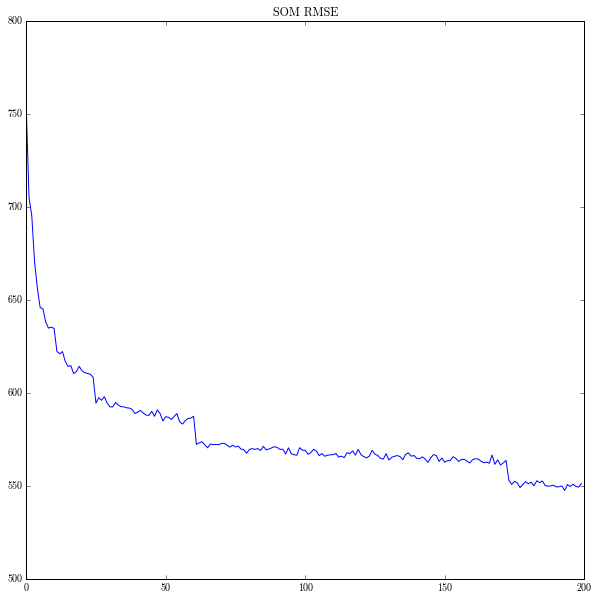

In [11]:
plt.figure(figsize=(10,10))
plt.plot(range(iterations),rmse)
plt.title('SOM RMSE')
# mysavefig('SOM-{0}x{0}-RMSE.png'.format(network_size[0]))

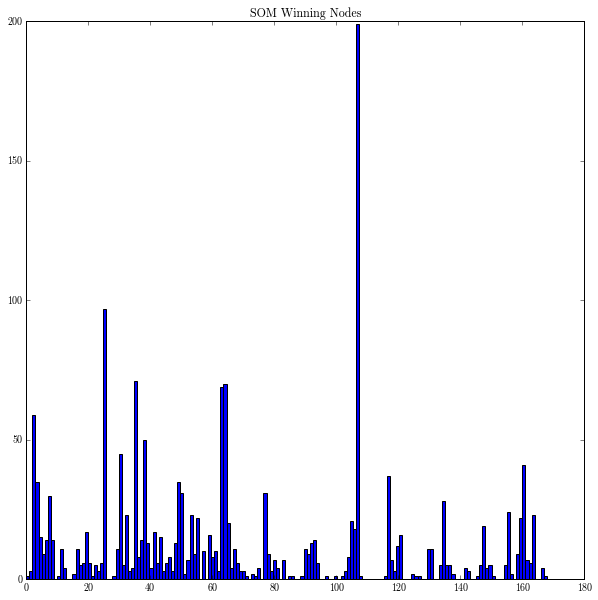

In [12]:
data = big_matrix
winning_node_list = np.zeros(data.shape[0])
for j in range(data.shape[0]):
    diff = trained_nodes-data[j,:]
    dist = np.sqrt(np.sum(diff**2,axis=(1)))
    winning_node_list[j] = dist.argmin()
plt.figure(figsize=(10,10))
n,bins,patches = plt.hist(winning_node_list,bins=num_nodes)
plt.title('SOM Winning Nodes')
# mysavefig('SOM-{0}x{0}-node-hist.png'.format(network_size[0]))

In [13]:
# now let's also plot them
def plot_clusters(clusters,data,cluster_centers,cluster_id,v=True,fix_ylim=True,fixed_ylim=[],xspacing=.01,investigate=False,save=True):
    # we are going to make plots of max width 3
    num_x = np.min([3,len(clusters)])
    num_y = np.ceil(len(clusters)/num_x)
    xspacing = .03
    yspacing = .03
    xoffset = .07
    yoffset = .07
    xwidth = (1.-xoffset)/(num_x)-xspacing
    yheight = (1.-yoffset)/(num_y)-yspacing
    print('xwidth is {0}'.format(xwidth))
    print('yheight is {0}'.format(yheight))
    
    # go compute the ybounds:
    calc_ylim = [100.0,-100.0]
    for cluster in clusters:
        c_max = data[cluster[0][:20],:].max()
        c_min = data[cluster[0][:20],:].min()
        calc_ylim[0] = np.min([calc_ylim[0],c_min])
        calc_ylim[1] = np.max([calc_ylim[1],c_max])
    if len(fixed_ylim) > 0:
        calc_ylim = fixed_ylim
        
    chars = 60
    
    scale_factor_x = 5
    scale_factor_y = 5*1.25
    if investigate:
        scale_factor_x = 10
        scale_factor_y = 10*1.25
    fig = plt.figure(figsize=(scale_factor_x*num_x,scale_factor_y*num_y))
    for i,cluster in enumerate(clusters):
        print(i)
        print("====")
        # print((i-i%num_x))
        # ind = np.argsort(w[:,sv+svstart])[-20:]
        ax1rect = [xoffset+(i%num_x)*(xspacing+xwidth),1.-yheight-yspacing-(int(np.floor((i-i%num_x)/num_x))*(yspacing+yheight))+yheight*.2,xwidth,yheight*.8]
        ax1 = fig.add_axes(ax1rect)
        ax1books_rect = ax1rect.copy()
        ax1books_rect[1] -= yheight*.2
        ax1books_rect[3] = yheight*.2
        ax1books = fig.add_axes(ax1books_rect)
        # ax1books.text?
        # ax.set_title('20 closest positive correlates')
        
        if v:
            print('-'*80)
            print('20 closest positive correlates:')
            # print(cluster)
        j=0
        for index,title in zip(*cluster):
            if j+1 > 20:
                break
            if investigate:
                ax1.plot(data[index],label="{} ({})".format(title,q[int(index)].gutenberg_id))
            else:
                ax1.plot(data[index],color=".4",label=None)
            # plt.plot(big_matrix_mean0[i],color=".4")
            if v:
                print(index,title)
            if j<5:
                ax1books.text(0.0,.8-j*.2,"{} ({})".format(title,q[int(index)].gutenberg_id),fontsize=10)
            j+=1
        ax1.plot(cluster_centers[cluster_id[i]],color="#ff6700",linewidth=2,label="Node {} Cluster {} ({})".format(cluster_id[i],i+1,len(cluster[0])))
        # ax1.set_xticklabels([])
        ax1.legend(loc="upper right")

        # ax1.axis('off')
        ax1books.axis('off')
        
        props = dict(boxstyle='square', facecolor='white', alpha=1.0)
        # fig.text(ax1rect[0]+.03/xwidth, ax1rect[1]+ax1rect[3]-.03/yheight, letters[i],
        if fix_ylim:
            my_ylim = calc_ylim
        else:
            my_ylim = ax1.get_ylim()
        ax1.text(.035*200, my_ylim[0]+.965*(my_ylim[1]-my_ylim[0]), letters[i],
                     fontsize=14,
                     verticalalignment='top',
                     horizontalalignment='left',
                     bbox=props)

        if fix_ylim:
            ax1.set_ylim(calc_ylim)
        if fix_ylim and i%num_x > 0:
            ax1.set_yticklabels([])
        if True: # i<num_x*(num_y-1): # only on the bottom row
            ax1.set_xticklabels([])
            
    if save:
        # mysavefig('SV{0}.svg'.format('4-6'))
        mysavefig("clustered-timeseries.png".format(),
                  folder="media/figures/SOM",
                  openfig=False)
        mysavefig("clustered-timeseries.pdf".format(),
                  folder="media/figures/SOM",
                  openfig=True)

In [18]:
allDistances = pickle.load(open("data/gutenberg/pairwise-distance-matrix-cache.p","rb"))
allDistancesCentered = pickle.load(open("data/gutenberg/pairwise-distance-mean0-matrix-cache.p","rb"))
allDistancesStart = pickle.load(open("data/gutenberg/pairwise-distance-start0-matrix-cache.p","rb"))

def cityBlock(a,b):
    return np.sum(np.abs(a-b))

def get_sorted(all_ind,center=[]):
    if len(center) ==  0:
        # go get the submatrix
        # allDistances[[1,2,3],:][:,[1,2,3]]
        submat = allDistances[all_ind,:][:,all_ind]
        # print(submat)
        distances = submat.sum(axis=0)
    else:
        # ---------
        # that did distance from the other stories...
        # let's look at distance from the SOM story?
        distances = [cityBlock(center,big_matrix_mean0[all_ind[i],:]) for i in all_ind]
    
    # print(distances)
    indices_sorted = sorted(range(len(all_ind)),key=lambda i: distances[i])
    all_ind_sorted = all_ind[indices_sorted]
    distances_sorted = distances[indices_sorted]
    # print(all_ind_sorted)
    # make sure they're sorted the right way!
    # print(distances_sorted)
    assert distances_sorted[0] < distances_sorted[1]
    titles_sorted = ["" for i in range(len(all_ind_sorted))]
    chars = 50
    for i,ind in enumerate(all_ind_sorted):
        b = q[int(ind)]
        if len(b.title) > chars:
            titles_sorted[i] = "{}. {}...".format(i+1,b.title[:chars-3].replace("\n",": ").replace("&","\&"))
        else:
            titles_sorted[i] = "{}. {}".format(i+1,b.title.replace("\n",": ").replace("&","\&"))
    return all_ind_sorted,titles_sorted

In [338]:
# let's look at what we have to build the data to plot. here are the trained nodes:

In [339]:
trained_nodes.shape

(169, 200)

In [14]:
winning_node_list.shape
# looks like a list of the winning node for each story

(1751,)

In [341]:
winning_node_list[:10]
# peek at the winning nodes

array([  55.,    6.,   18.,  149.,   63.,  160.,  159.,    5.,    5.,  159.])

In [342]:
n
# this is binned onto each node index by plt.hist() (count of wins by node)

array([  36.,   11.,    3.,    0.,   10.,  102.,  154.,   11.,    4.,
          7.,   46.,   26.,   17.,    7.,    2.,    0.,    0.,    0.,
         85.,   28.,    1.,    0.,    3.,   24.,   19.,    8.,   24.,
          8.,    0.,    0.,    6.,    0.,    4.,   14.,   14.,   37.,
          4.,   14.,   14.,   10.,    2.,   17.,   11.,    3.,    2.,
          0.,    1.,   81.,   17.,    3.,    2.,    1.,    2.,    0.,
          0.,   15.,    2.,    0.,    0.,    6.,   14.,   28.,   19.,
          4.,   13.,    2.,    4.,    6.,   10.,   26.,    0.,   13.,
          3.,    5.,    0.,   34.,   17.,   29.,    2.,    3.,    0.,
          0.,   18.,    8.,   10.,    1.,    0.,    0.,    1.,   22.,
        103.,   16.,    4.,    0.,    0.,    3.,    8.,    6.,    0.,
          0.,    0.,    0.,   13.,    7.,    0.,    3.,   15.,    6.,
          9.,    0.,    2.,    0.,    0.,    0.,    0.,    0.,    7.,
          0.,    1.,    7.,    4.,    0.,    1.,    0.,    0.,    3.,
          1.,    0.,

In [343]:
len(n)
# make sure I have 100 bins

169

In [20]:
# must have done a 10x10!
# let's rebuild n anyway
n_nodes = [np.nonzero(winning_node_list==i)[0] for i in range(num_nodes)]
print(n_nodes)
n = list(map(len,n_nodes))
print(n)

[array([678]), array([ 407, 1246, 1282]), array([  19,   58,   59,   69,  153,  178,  195,  197,  269,  294,  357,
        508,  533,  552,  593,  608,  646,  660,  666,  667,  762,  789,
        795,  821,  866,  867,  987, 1033, 1035, 1049, 1063, 1075, 1090,
       1192, 1194, 1217, 1230, 1245, 1271, 1287, 1300, 1337, 1361, 1392,
       1394, 1407, 1424, 1434, 1463, 1468, 1498, 1533, 1539, 1565, 1580,
       1596, 1609, 1647, 1664]), array([   2,   42,   61,   76,  128,  155,  171,  212,  213,  231,  280,
        302,  327,  397,  454,  542,  651,  661,  801,  822,  845, 1052,
       1106, 1113, 1163, 1207, 1371, 1455, 1512, 1561, 1574, 1665, 1681,
       1707, 1711]), array([ 305,  349,  384,  534,  920,  960, 1019, 1040, 1053, 1142, 1148,
       1164, 1210, 1464, 1678]), array([  29,   51,  307,  492,  695,  842,  953, 1028, 1586]), array([ 134,  283,  360,  535,  638,  914,  967, 1003, 1166, 1173, 1214,
       1219, 1355, 1474]), array([ 140,  188,  196,  218,  255,  382,  478,  4

In [16]:
n_indexer = sorted(range(len(n)),key=lambda i: n[i],reverse=True)
# let's sort the winning nodes
print(n_indexer)

[107, 25, 35, 64, 63, 2, 38, 30, 161, 117, 3, 49, 50, 77, 7, 135, 156, 32, 53, 164, 55, 160, 105, 65, 148, 106, 19, 41, 59, 121, 4, 43, 6, 8, 37, 93, 39, 48, 92, 120, 11, 16, 29, 67, 90, 130, 131, 57, 61, 5, 54, 78, 91, 159, 36, 46, 60, 104, 52, 80, 83, 118, 162, 18, 20, 24, 42, 45, 68, 94, 163, 17, 22, 31, 134, 136, 137, 147, 150, 155, 12, 34, 40, 66, 75, 81, 142, 149, 167, 1, 23, 33, 44, 47, 62, 69, 70, 79, 103, 119, 143, 15, 51, 73, 125, 138, 157, 0, 10, 21, 28, 71, 74, 85, 86, 89, 97, 100, 102, 108, 116, 126, 127, 146, 151, 168, 9, 13, 14, 26, 27, 56, 58, 72, 76, 82, 84, 87, 88, 95, 96, 98, 99, 101, 109, 110, 111, 112, 113, 114, 115, 122, 123, 124, 128, 129, 132, 133, 139, 140, 141, 144, 145, 152, 153, 154, 158, 165, 166]


In [346]:
n_sorted = [n[n_i] for n_i in n_indexer]

In [347]:
n_sorted[:9]
# okay, now we have sorted counts

[154, 103, 102, 85, 81, 68, 49, 47, 47]

In [348]:
n_indexer[:9]
# and the sorted nodes

[6, 90, 5, 18, 47, 168, 159, 160, 167]

In [349]:
winning_node_list==n_indexer[0]
# these are the stories that match winning node 1

array([False,  True, False, ..., False,  True, False], dtype=bool)

In [350]:
np.nonzero(winning_node_list==82)
# here are their indices

(array([  17,   19,   20,  117,  270,  406,  522,  547,  722,  731,  894,
         973, 1082, 1085, 1136, 1170, 1207, 1543]),)

In [351]:
len(np.nonzero(winning_node_list==82)[0])
# and BOOM there are 59 of them

18

In [21]:
clusters = [get_sorted(n_nodes[n_i]) for n_i in n_indexer[:9]]
# clusters = []

xwidth is 0.28
yheight is 0.28
0
====
1
====
2
====
3
====
4
====
5
====
6
====
7
====
8
====


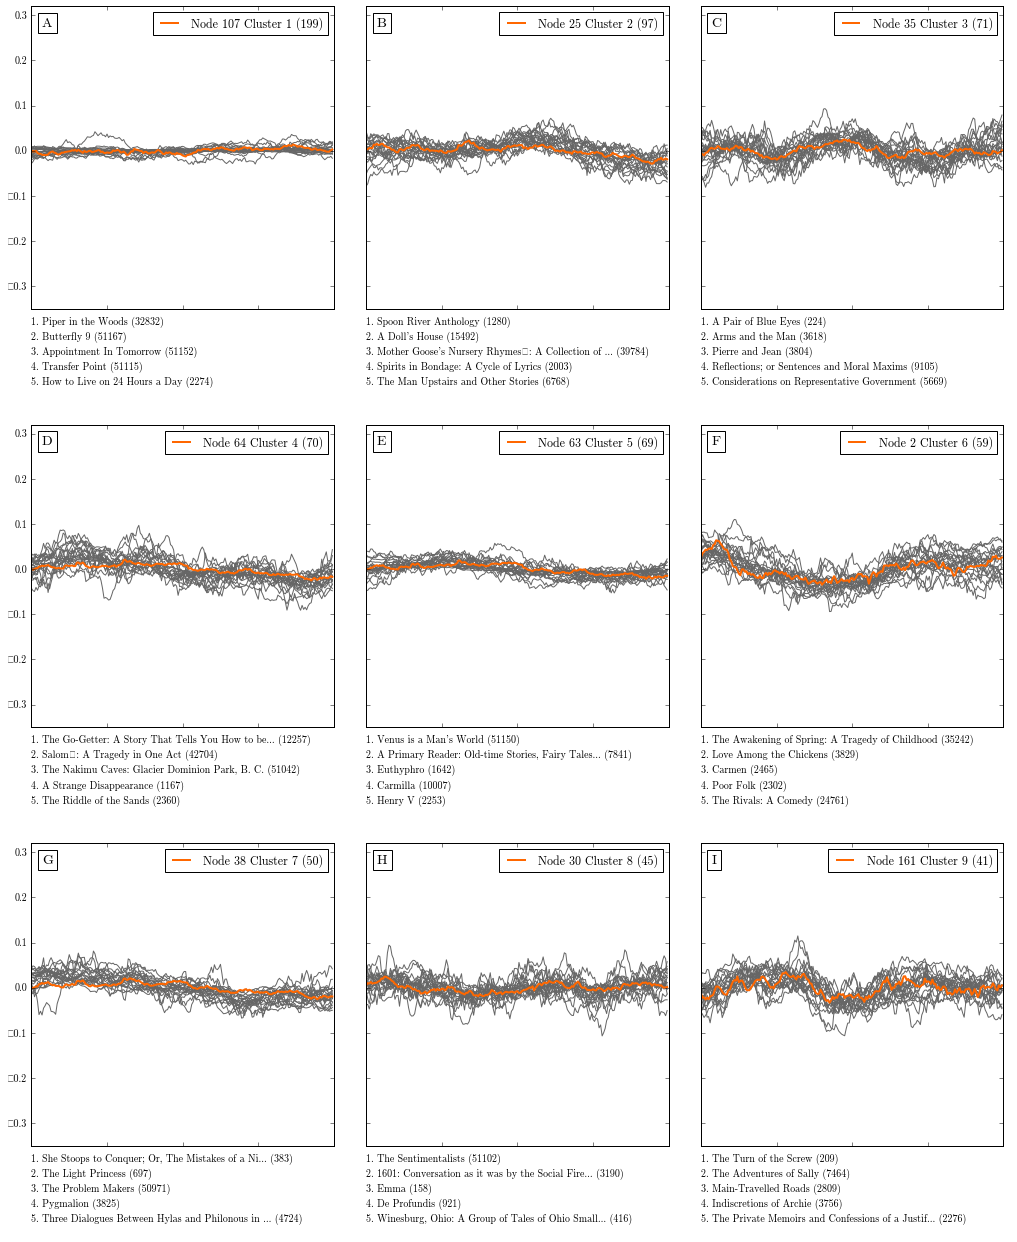

In [23]:
plot_clusters(clusters,big_matrix_mean0,trained_nodes,n_indexer,v=False,fix_ylim=True,fixed_ylim=[-.35,.32],xspacing=.01,investigate=False,save=True)

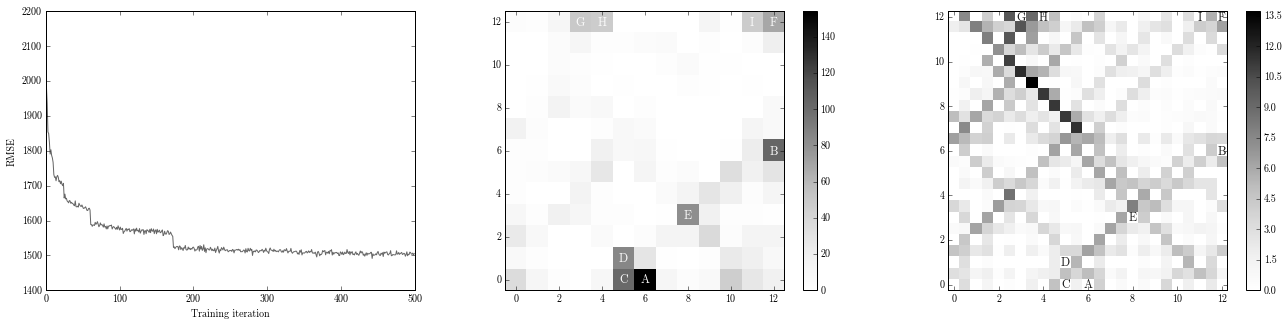

In [371]:
plt.figure(figsize=(22.5,5))
fig = plt.subplot(1,3,1)
# ax = fig.add_axes([.2,.2,.7,.7])
# plt.figure(figsize=(10,10))
plt.plot(range(iterations),rmse,color=".4",label="RMSE",linewidth=1)
plt.xlabel("Training iteration")
plt.ylabel("RMSE")
# mysavefig('SOM-{0}x{0}-RMSE.png'.format(network_size[0]))

plt.subplot(1,3,3)
plot_B_matrix(trained_nodes,network_size,cmap="Greys",d=cityBlock,shrink=1)
for i in range(9):
    if i==0:
        color=".1"
    else:
        color=".1"
    plt.text(mysub2ind(n_indexer[i],network_size[0],network_size[0])[1],
             mysub2ind(n_indexer[i],network_size[0],network_size[0])[0],
             letters[i],
             ha="center",
             va="center",
             fontsize=12,
             color=color)
# plt.colorbar(shrink=.73)
# ax = plt.gca() 
# ax.set_yticklabels([])
plt.subplot(1,3,2)
plt.imshow(np.reshape(n,network_size), aspect=1, cmap=plt.get_cmap('Greys'), origin='lower', interpolation='nearest', ) #extent=(-0.25,network_size[0]-0.75,-0.25,network_size[1]-0.75))
plt.colorbar(shrink=1)
plt.xlim()
for i in range(9):
    if i==0:
        color=".99"
    else:
        color=".99"
    plt.text(mysub2ind(n_indexer[i],network_size[0],network_size[0])[1],
             mysub2ind(n_indexer[i],network_size[0],network_size[0])[0],
             letters[i],
             ha="center",
             va="center",
             fontsize=12,
             color=color)

mysavefig("heatmap+Bmatrix-greys-labeled.pdf",folder="media/figures/SOM/",openfig=True,)

In [295]:
cityBlock(trained_nodes[n_indexer[1],:],trained_nodes[n_indexer[2],:])

7.9863595433479215

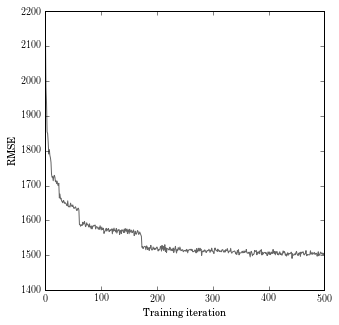

In [380]:
rc('text', usetex='true') 

plt.figure(figsize=(5,5))
# fig = plt.subplot(1,3,1)
# ax = fig.add_axes([.2,.2,.7,.7])
# plt.figure(figsize=(10,10))
plt.plot(range(iterations),rmse,color=".4",label="RMSE",linewidth=1)
plt.xlabel("Training iteration")
plt.ylabel("RMSE")
# mysavefig('SOM-{0}x{0}-RMSE.png'.format(network_size[0]))



mysavefig("training.pdf",folder="media/figures/SOM/",openfig=True,)

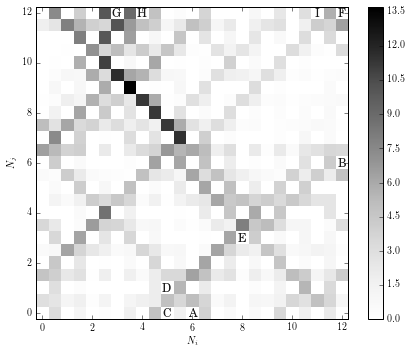

In [383]:

plt.figure(figsize=(7,7))

plot_B_matrix(trained_nodes,network_size,cmap="Greys",d=cityBlock,shrink=.8)
for i in range(9):
    if i==0:
        color=".1"
    else:
        color=".1"
    plt.text(mysub2ind(n_indexer[i],network_size[0],network_size[0])[1],
             mysub2ind(n_indexer[i],network_size[0],network_size[0])[0],
             letters[i],
             ha="center",
             va="center",
             fontsize=12,
             color=color)
plt.xlabel("$N_i$")
plt.ylabel("$N_j$")

mysavefig("Bmatrix-labeled.pdf",folder="media/figures/SOM/",openfig=True,)


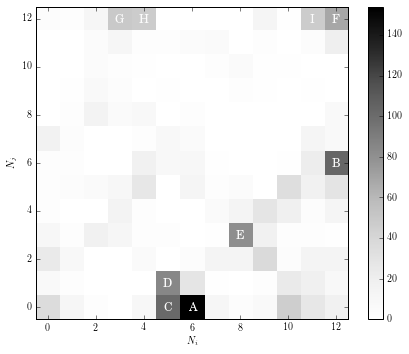

In [384]:
plt.figure(figsize=(7,7))

plt.imshow(np.reshape(n,network_size), aspect=1, cmap=plt.get_cmap('Greys'), origin='lower', interpolation='nearest', ) #extent=(-0.25,network_size[0]-0.75,-0.25,network_size[1]-0.75))
plt.colorbar(shrink=.8)
plt.xlim()
for i in range(9):
    if i==0:
        color=".99"
    else:
        color=".99"
    plt.text(mysub2ind(n_indexer[i],network_size[0],network_size[0])[1],
             mysub2ind(n_indexer[i],network_size[0],network_size[0])[0],
             letters[i],
             ha="center",
             va="center",
             fontsize=12,
             color=color)
    
plt.xlabel("$N_i$")
plt.ylabel("$N_j$")


mysavefig("heatmap-labeled.pdf",folder="media/figures/SOM/",openfig=True,)

In [ ]:
# ~/tools/shell/2015-08-kitchentabletools/pdftile.pl 1 2 0.48 3 0 l 8 "" "" 2016-03-11-15-13-Bmatrix-labeled.pdf "" 2016-03-11-15-14-heatmap-labeled.pdf SOM-matrices
# ~/tools/shell/2015-08-kitchentabletools/pdftile.pl 1 3 0.3 3 0 l 8 "" "" 2016-03-11-15-10-training.pdf "" 2016-03-11-15-13-Bmatrix-labeled.pdf "" 2016-03-11-15-14-heatmap-labeled.pdf SOM
